# COMSW4995 - Applied Machine Learning - Hw 2

#### Hojin Lee (hl3328)

## Task1:  Classification on the ‘credit-g’ dataset 

In [423]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, GridSearchCV
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [385]:
#reading data frame
directory = os.path.join(os.getcwd(),'Data/dataset_31_credit-g.csv')
credit_df = pd.read_csv(directory)
credit_df.shape

(1000, 21)

#### Task1.1 Determine which features are continuous and which are categorical.

In [386]:
#taking columns of object 
print('Categorical feature:',list(credit_df.select_dtypes(include=['object']).columns))
print('Continuous feature:',list(credit_df.select_dtypes(exclude=['object']).columns))



Categorical feature: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']
Continuous feature: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


#### Task 1.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

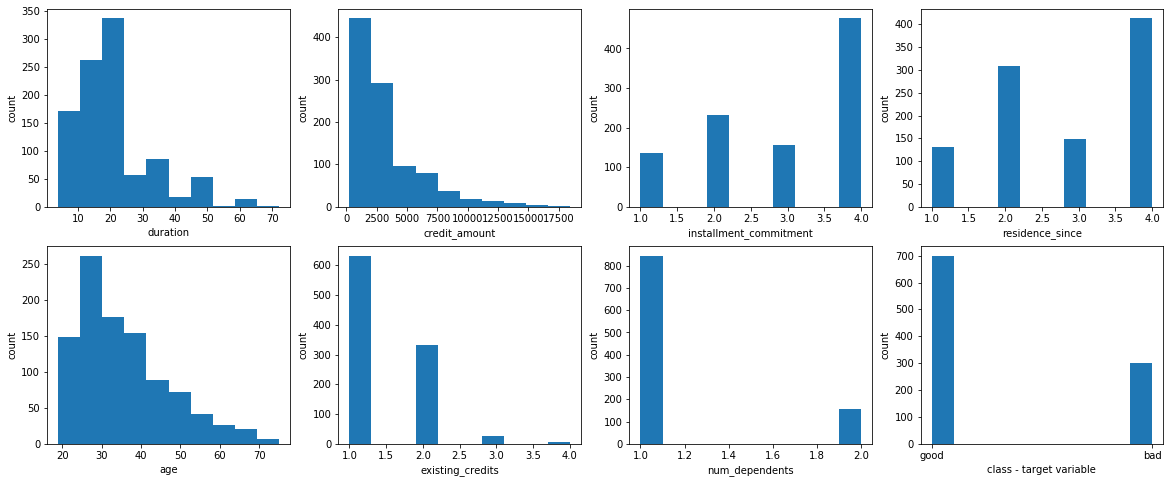

In [387]:
continuous_col = list(credit_df.select_dtypes(exclude=['object']).columns)
#adding the target variable
continuous_col.append('class')
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
counter = 0

for i in range(2):
    for j in range(4):
        
        col = continuous_col[counter]
        ax[i,j].hist(credit_df[col]);
        ax[i,j].set_xlabel(col);
        ax[i,j].set_ylabel("count");
        
        counter += 1
ax[i,j].set_xlabel('class - target variable');


#### Task 1.3 Split data into training and test set. Do not use the test set until a final evaluation in 1.5. Preprocess the data (scaling, treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.

In [388]:
X = credit_df.loc[:, credit_df.columns != 'class']
y = credit_df['class']

#treatment / one-hot-encoding of categorical data
X_encoding = pd.get_dummies(X)

#train-test-validation set splitting
X_train, X_test, y_train, y_test = train_test_split(X_encoding, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

logreg = LogisticRegression().fit(X_train, y_train)
validation = logreg.predict(X_val)

count_misclassified = (y_val != validation).sum()
print('Number of misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_val, validation)
print('Accuracy: {:.2f}'.format(accuracy))


Number of misclassified samples: 34
Accuracy: 0.79


#### 1.4 Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate Logistic Regression, linear support vector machines and nearest neighbors using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

categorical = X.dtypes == object

#two separate preprocessors with and without StandardScaler()
preprocess_without_scaler = make_column_transformer(
    (OneHotEncoder(), categorical))

preprocess_with_scaler = make_column_transformer(
    (OneHotEncoder(), categorical),
    (StandardScaler(), ~categorical))

results_dict= {}
methods = [LogisticRegression(), KNeighborsClassifier(), LinearSVC()]
processors = [preprocess_with_scaler, preprocess_without_scaler]
method_name = ['Logistic_Regression', 'K_Neighbors', 'Linear_SVC']
processors_name = ['preprocess_with_scaler', 'preprocess_without_scaler']

processor_counter = 0

for processor in processors:
    method_counter = 0
    results_dict[processors_name[processor_counter]] = {}
    
    for method in methods:
        
        results_dict[processors_name[processor_counter]][method_name[method_counter]] = np.mean(
             cross_val_score(make_pipeline(processor, method), X_train, y_train, cv=10))
        method_counter += 1
        
    processor_counter += 1
        
results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='psql'))



+---------------------+--------------------------+-----------------------------+
|                     |   preprocess_with_scaler |   preprocess_without_scaler |
|---------------------+--------------------------+-----------------------------|
| Logistic_Regression |                  0.74625 |                     0.72875 |
| K_Neighbors         |                  0.71875 |                     0.70375 |
| Linear_SVC          |                  0.7475  |                     0.7375  |
+---------------------+--------------------------+-----------------------------+


Evaluation result for Logistic Regression, linear support vector machines and nearest neighbors using cross-validation was somewhat similar to each other. Regardless of the scaler, they all had cross-validation score around 70 to 75. On the other hand, the scaling made the performance slightly better for Logistic Regression and linear svc while it did not improve nearest neighbor method, yet made it slightly worse, but not so significantly. 

#### 1.5 Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the be model on the test set. Visualize the performance as function of the parameters for all three models.

==========  ============================  ========================================  ===================
..          Log_Reg                       K_Neighbors                               Linear_SVC
==========  ============================  ========================================  ===================
best score  0.7463                        0.735                                     0.7475
best param  {'logisticregression__C': 1}  {'kneighborsclassifier__n_neighbors': 9}  {'linearsvc__C': 1}
==========  ============================  ========================================  ===================


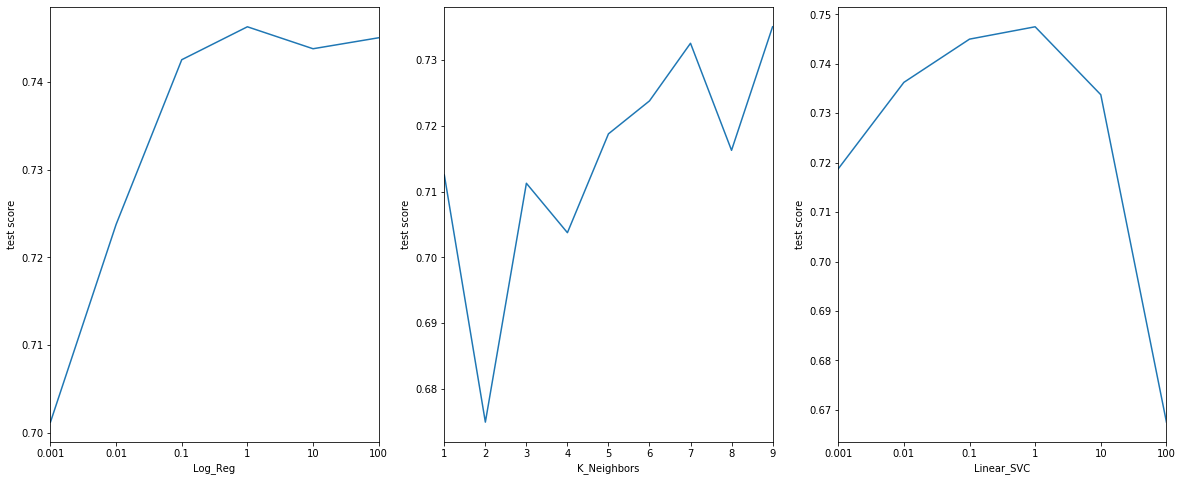

In [413]:
methods = [LogisticRegression(), KNeighborsClassifier(), LinearSVC()]
method_name = ['Log_Reg', 'K_Neighbors', 'Linear_SVC']
results_dict = {}
processor = preprocess_with_scaler

#grid search parameters
param_grids = {'Log_Reg':{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
               , 'K_Neighbors': {'kneighborsclassifier__n_neighbors':  range(1, 10)}
               , 'Linear_SVC': {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}}

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

method_counter = 0
for method in methods:
    param_grid = param_grids[method_name[method_counter]]
    model = GridSearchCV(make_pipeline(processor, method), param_grid, cv=10)
    model.fit(X_train, y_train)
    
    results_dict[method_name[method_counter]] = {}
    results_dict[method_name[method_counter]]['best score'] = (round(model.best_score_,4))
    results_dict[method_name[method_counter]]['best param'] = model.best_params_
                                                               
    pd.DataFrame(model.cv_results_['mean_test_score'],list(map(str, list(param_grid.values())[0]))).plot(ax=ax[method_counter])
    ax[method_counter].get_legend().remove()
    ax[method_counter].set_xlabel(method_name[method_counter]);
    ax[method_counter].set_ylabel("test score");
    method_counter+=1
    

results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='rst'))
    

The results after tuning the parameters with GridSearchCV slightly improved, but not so signficantly. I have visualized the change in performance as function of the parameters. Also, since the support vector machines had the highest score for GridSearchCV, I have evaluated the model with the test set, and the test score turned out to be 0.760. 

#### 1.6 Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [328]:
#Kfold and stratified Kfold declaration
skfold = StratifiedKFold(n_splits=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

folds = [skfold, kfold]
methods = [logreg_model_with_scaler, knn_model_with_scaler, linearSVM_model_with_scaler]
fold_name = ['stratified k-fold', 'Kfold with shuffling']
method_name = ['Log_Reg', 'K_Neighbors', 'Linear_SVC']
results_dict = {}

param_grids = {'Log_Reg':{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
               , 'K_Neighbors': {'kneighborsclassifier__n_neighbors':  range(1, 10)}
               , 'Linear_SVC': {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}}

fold_counter = 0

for fold in folds:
    method_counter = 0
    results_dict[fold_name[fold_counter]] = {}
    
    for method in methods:
        param_grid = param_grids[method_name[method_counter]]
        model = GridSearchCV(method, param_grid=param_grid, cv=fold)
        model.fit(X_train, y_train)
        
        results_dict[fold_name[fold_counter]][method_name[method_counter]] = (round(model.best_score_,4),model.best_params_)
        method_counter += 1
        
    fold_counter += 1

results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='rst'))
    

===========  ==================================================  ================================================
..           stratified k-fold                                   Kfold with shuffling
===========  ==================================================  ================================================
Log_Reg      (0.7638, {'logisticregression__C': 0.1})            (0.7638, {'logisticregression__C': 0.1})
K_Neighbors  (0.7425, {'kneighborsclassifier__n_neighbors': 5})  (0.75, {'kneighborsclassifier__n_neighbors': 6})
Linear_SVC   (0.7662, {'linearsvc__C': 0.1})                     (0.7625, {'linearsvc__C': 0.1})
===========  ==================================================  ================================================


Cross validation scores remained almost same for stratified k-fold and K fold with shuffling. Also, the parameters found respectively were slightly different but almost same.

In [329]:
#Kfold with different random seed shuffling
kfold_1 = KFold(n_splits=10, shuffle=True, random_state=1)
kfold_2 = KFold(n_splits=10, shuffle=True, random_state=2)
kFolds = [kfold_1, kfold_2]
kFolds_name = ['random_1', 'random_2']
methods = [logreg_model_with_scaler, knn_model_with_scaler, linearSVM_model_with_scaler]
method_name = ['Log_Reg', 'K_Neighbors', 'Linear_SVC']

results_dict = {}

param_grids = {'Log_Reg':{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
               , 'K_Neighbors': {'kneighborsclassifier__n_neighbors':  range(1, 10)}
               , 'Linear_SVC': {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}}

fold_counter = 0

for fold in kFolds:
    method_counter = 0
    results_dict[kFolds_name[fold_counter]] = {}
    
    for method in methods:
        param_grid = param_grids[method_name[method_counter]]
        model = GridSearchCV(method, param_grid=param_grid, cv=fold)
        model.fit(X_train, y_train)
        
        results_dict[kFolds_name[fold_counter]][method_name[method_counter]] = (round(model.best_score_,4),model.best_params_)
        method_counter += 1
        
    fold_counter += 1

results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='rst'))


===========  ================================================  ==================================================
..           random_1                                          random_2
===========  ================================================  ==================================================
Log_Reg      (0.7638, {'logisticregression__C': 0.1})          (0.7587, {'logisticregression__C': 0.1})
K_Neighbors  (0.75, {'kneighborsclassifier__n_neighbors': 6})  (0.7425, {'kneighborsclassifier__n_neighbors': 6})
Linear_SVC   (0.7625, {'linearsvc__C': 0.1})                   (0.76, {'linearsvc__C': 0.1})
===========  ================================================  ==================================================


For change of randomness of shuffling, both the cross-validation score and the best parameter remained same.

In [330]:
#Train-test-set with different random seed shuffling
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=2)

train_sets = [[X_train1, y_train1],[X_train2, y_train2]]
train_sets_name = ['random_1', 'random_2']

methods = [logreg_model_with_scaler, knn_model_with_scaler, linearSVM_model_with_scaler]
method_name = ['Log_Reg', 'K_Neighbors', 'Linear_SVC']

results_dict = {}

param_grids = {'Log_Reg':{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
               , 'K_Neighbors': {'kneighborsclassifier__n_neighbors':  range(1, 10)}
               , 'Linear_SVC': {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}}

random_counter = 0

for sets in train_sets:
    method_counter = 0
    results_dict[train_sets_name[random_counter]] = {}
    
    for method in methods:
        param_grid = param_grids[method_name[method_counter]]
        model = GridSearchCV(method, param_grid=param_grid, cv=fold)
        model.fit(sets[0], sets[1])
        
        results_dict[train_sets_name[random_counter]][method_name[method_counter]] = (round(model.best_score_,4),model.best_params_)
        method_counter += 1
        
    random_counter += 1

results_df = pd.DataFrame.from_dict(results_dict)
print(tabulate(results_df, headers='keys', tablefmt='rst'))


===========  ==================================================  ==================================================
..           random_1                                            random_2
===========  ==================================================  ==================================================
Log_Reg      (0.7525, {'logisticregression__C': 10})             (0.78, {'logisticregression__C': 0.1})
K_Neighbors  (0.7588, {'kneighborsclassifier__n_neighbors': 5})  (0.7537, {'kneighborsclassifier__n_neighbors': 5})
Linear_SVC   (0.755, {'linearsvc__C': 10})                       (0.7762, {'linearsvc__C': 0.1})
===========  ==================================================  ==================================================


Change of the random state of split of training and test data had a bigger change in both cross-validation score and the best parameter chosen compared to changing of k fold strategy and random seed of shuffling. Although the best parameter for the nearest neighborhood method remained the same, the other two method had different parameters.

#### 1.7 Visualize the 20 most important coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [ ]:
log_reg_model = log_reg.fit(X_train, y_train)
log_reg_coef = log_reg_model[-1].coef_[0]

svm_model = svm.fit(X_train, y_train)
svm_model_coef = svm_model[-1].coef_[0]

# Indices of 20 most important coefficients
log_reg_idx = np.argpartition(abs(log_reg_coef), -20)[-20:]
svm_model_idx = np.argpartition(abs(svm_model_coef), -20)[-20:]

# Values of 20 most important coefficients
log_reg_coef_top = log_reg_coef[log_reg_idx]
svm_model_coef_top = svm_model_coef[svm_model_idx]

ohe_columns = log_reg.named_steps['columntransformer'].transformers_[1][1].get_feature_names().tolist()

continuous_columns = []
for i in range(len(df_features.dtypes)):
    if df_features.dtypes[i] == 'int64':
        continuous_columns.append(df_features.dtypes.index[i])
preprocess_columns = continuous_columns + ohe_columns

preprocess_array = np.array(preprocess_columns)

# Column labels of important features
preprocess_columns_log = preprocess_array[log_reg_idx]
preprocess_columns_svm = preprocess_array[svm_model_idx]